## _(3) - Segmenting Stage_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

### _Config File_

In [6]:
# load processing config file (trusted source)
config_path = 'LightningModules/Segmenting/configs/segment_quickstart.yaml'
config_file = os.path.join(os.curdir, config_path)
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [7]:
config["input_dir"] = 'run_all/gnn_processed/test'

### _Input Data_

In [8]:
# fetch all files
inputdir = config["input_dir"]
gnn_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [9]:
gnn_files[:5]

['run_all/gnn_processed/test/5000',
 'run_all/gnn_processed/test/5001',
 'run_all/gnn_processed/test/5002',
 'run_all/gnn_processed/test/5003',
 'run_all/gnn_processed/test/5004']

In [10]:
gnn_data = torch.load(gnn_files[0], map_location=device)
print("Length of Data: {}".format(len(gnn_data)))

Length of Data: 11


In [11]:
gnn_data

Data(x=[148, 3], pid=[148], layers=[148], event_file='/global/cscratch1/sd/aakram/train_all/event0000095000', hid=[148], pt=[148], modulewise_true_edges=[2, 139], layerwise_true_edges=[2, 143], edge_index=[2, 961], y_pid=[961], scores=[1922])

## _CCL with Walkthrough_

- Run CCL Algorithm to Label Graphs
- Run Walkthrough Algorithm on Labelled Graphs


IDEA: Using CCL with low cut, one can force CCL not to break the component but rather keep the crossing tracks as single piece. Then build subgraphs from the connected-components and run walkthrough on these subgraphs. The subgraphs that are isolated tracks, the result will be trivial. For crossing tracks, Walkthrough should extract more tracks.

In [19]:
import scipy.sparse as sps
import scipy.sparse.csgraph as scigraph
from torch_geometric.utils import to_scipy_sparse_matrix

In [20]:
event_idx = 1
input_file = gnn_files[event_idx]

In [21]:
graph = torch.load(input_file, map_location=device)
graph.scores = graph.scores[:graph.edge_index.shape[1]]  # resize to edge_index

In [22]:
graph.edge_index.shape[1], graph.scores.shape[0]

(808, 808)

In [23]:
edge_cut = 0.25
e_mask = graph.scores > edge_cut

In [24]:
new_graph = graph.clone()
new_graph.edge_index = new_graph.edge_index[:, e_mask]
new_graph.scores = new_graph.scores[e_mask]

In [25]:
new_graph.edge_index.shape[1], new_graph.scores.shape[0]

(183, 183)

In [29]:
# Create a sparse matrix representation of the graph with edge scores
adj_matrix = to_scipy_sparse_matrix(new_graph.edge_index, num_nodes=new_graph.x.size(0))

In [30]:
# Compute the connected components using SciPy
n_components, labels = scigraph.connected_components(csgraph=adj_matrix, directed=False, return_labels=True)

In [31]:
labels

array([0, 1, 2, 3, 2, 1, 4, 5, 6, 7, 0, 2, 1, 2, 5, 3, 1, 4, 6, 7, 2, 2,
       3, 1, 1, 0, 5, 6, 4, 7, 7, 2, 1, 0, 2, 5, 1, 3, 1, 6, 4, 7, 2, 2,
       1, 1, 0, 5, 3, 6, 4, 4, 7, 0, 1, 5, 1, 1, 3, 2, 2, 6, 4, 4, 7, 0,
       2, 1, 1, 3, 2, 5, 6, 7, 0, 4, 1, 5, 2, 2, 1, 3, 6, 4, 7, 4, 4, 2,
       5, 2, 1, 0, 3, 6, 5, 2, 2, 1, 1, 6, 0, 3, 7, 2, 5, 2, 1, 0, 3, 6,
       1, 1, 5, 2, 7, 2, 1, 0, 3, 6, 1, 5, 2, 1, 2, 7, 0, 6, 3, 1, 5, 2,
       1, 2, 7, 0, 6, 3, 5, 2, 1, 1, 2, 6, 7, 1, 3, 0, 5, 2, 2, 1, 6, 0,
       3, 7, 1, 5, 2, 2, 1, 6, 0, 3, 1, 7, 5, 2, 2, 1, 1], dtype=int32)

- Run Walkthrough

In [32]:
import networkx as nx
from torch_geometric.utils import to_networkx

In [34]:
# Convert to NetworkX DiGraph
G = to_networkx(new_graph, to_undirected=False)
G.remove_nodes_from(list(nx.isolates(G)))

In [35]:
# CCL on NetworkX Graph ~ CCL on PyG Graph
# sparse_matrix = nx.to_scipy_sparse_matrix(G)
# n_components, labels = scigraph.connected_components(sparse_matrix, directed=False)

In [83]:
n_components

8

In [84]:
labels

array([0, 1, 2, 3, 2, 1, 4, 5, 6, 7, 0, 2, 1, 2, 5, 3, 1, 4, 6, 7, 2, 2,
       3, 1, 1, 0, 5, 6, 4, 7, 7, 2, 1, 0, 2, 5, 1, 3, 1, 6, 4, 7, 2, 2,
       1, 1, 0, 5, 3, 6, 4, 4, 7, 0, 1, 5, 1, 1, 3, 2, 2, 6, 4, 4, 7, 0,
       2, 1, 1, 3, 2, 5, 6, 7, 0, 4, 1, 5, 2, 2, 1, 3, 6, 4, 7, 4, 4, 2,
       5, 2, 1, 0, 3, 6, 5, 2, 2, 1, 1, 6, 0, 3, 7, 2, 5, 2, 1, 0, 3, 6,
       1, 1, 5, 2, 7, 2, 1, 0, 3, 6, 1, 5, 2, 1, 2, 7, 0, 6, 3, 1, 5, 2,
       1, 2, 7, 0, 6, 3, 5, 2, 1, 1, 2, 6, 7, 1, 3, 0, 5, 2, 2, 1, 6, 0,
       3, 7, 1, 5, 2, 2, 1, 6, 0, 3, 1, 7, 5, 2, 2, 1, 1], dtype=int32)

In [45]:
indices = np.where(labels == 0)[0]
indices

array([  0,  10,  25,  33,  46,  53,  65,  74,  91, 100, 107, 117, 126,
       135, 147, 153, 162])

In [46]:
subgraph = G.subgraph(indices)

In [48]:
paths = []

In [75]:
# get paths from components
for i in range(num_components):
    indices = np.where(labels == i)[0]
    subgraph = G.subgraph(indices)
    for source, target in subgraph.edges():
        for path in nx.all_simple_paths(subgraph, source=source, target=target):
            paths.append(path)

- Here I am trying to use your code to build the `track_df` similar to what I get from `eval/trkx_from_gnn.py` if we save this file then I can easily run `eval/eval_reco_trkx.py` that will output track efficiency, purity etc. I think I failed here. Or something is not right in builiding `paths` list.

In [76]:
from itertools import chain

In [85]:
track_df = pd.DataFrame(
    {
        "hit_id": list(chain.from_iterable(paths)),
        "track_id": list(chain.from_iterable([[i] * len(p) for i, p in enumerate(paths)])),
    }
)

# Remove duplicates on hit_id: TODO: In very near future, handle multiple tracks through the same hit!
track_df = track_df.drop_duplicates(subset="hit_id")

In [86]:
hit_id = track_df.hit_id
track_id = track_df.track_id

track_id_tensor = torch.ones(len(graph.x), dtype=torch.long) * -1
track_id_tensor[hit_id.values] = torch.from_numpy(track_id.values)

new_graph.labels = track_id_tensor

In [87]:
new_graph.labels

tensor([  0,  16,  64, 102,  67,  20, 117, 136, 153, 170,   0,  64,  16,  65,
        136, 102,  20, 117, 153, 170,  72,  70, 109,  24,  21,   6, 141, 159,
        122, 175, 176,  75,  27,   1,  74, 135,  30, 103,  28, 152, 118, 171,
         79,  81,  35,  38,   1, 135, 103, 152, 118, 119, 171,   9,  39, 142,
         40,  41, 110,  83,  82, 158, 123, 124, 167,   2,  85,  45,  47, 104,
         84, 137, 154, 167,   2, 120,  51, 137,  87,  86,  50, 104, 154, 127,
        172, 120, 121,  88, 140,  90,  52,   7, 111, 160, 146,  91,  92,  54,
         53, 151,   4, 105, 168,  93, 138,  94,  55,   4, 105, 151,  56,  57,
        138,  95, 168,  96,  58,   8, 108, 156,  59, 143,  97,  61,  98, 174,
         12, 162, 101,  17, 134,  66,  19,  69, 169,   5, 155, 101, 134,  66,
         19,  17,  69, 155, 169,  18, 107,   5, 139,  71,  73,  22, 157,   3,
        106, 173,  23, 144,  76,  77,  32, 163,   3, 106,  33, 180, 149,  78,
         80,  36,  34])

In [93]:
# I dnot want to change rest of the code, re-assign
labeled_graph = new_graph

### _Plotting the CC_

In [94]:
from src.drawing import detector_layout
from src.utils_math import polar_to_cartesian

- use `labeled_graph` for plotting

In [95]:
# pids for true_track, unique labels for reco_tracks
true_track, reco_track = labeled_graph, labeled_graph

In [96]:
# event id from the file itself
e_id = int(new_graph.event_file[-10:])
e_id

95001

In [97]:
r, phi, ir = labeled_graph.x.T
ir = ir.detach().numpy()*100
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

- use `pid` to indentify true tracks.

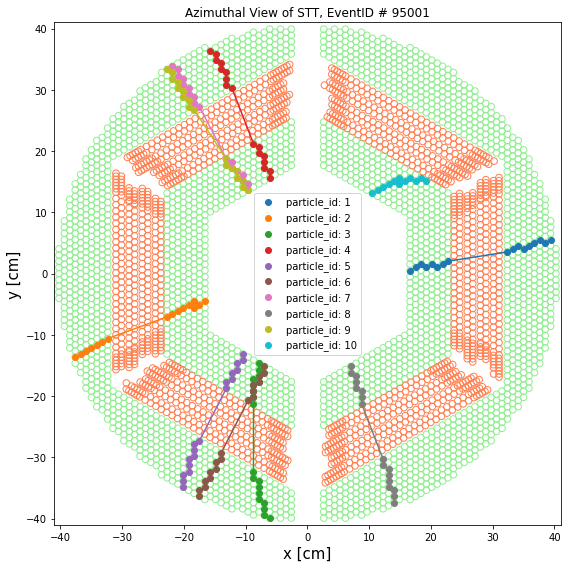

In [98]:
# plot true event
fig, ax = detector_layout(figsize=(8,8))
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

- use `labels` as `pid` to identify reconstructed tracks.
- **problem might lie here**

/tmp/ipykernel_1000801/710431381.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


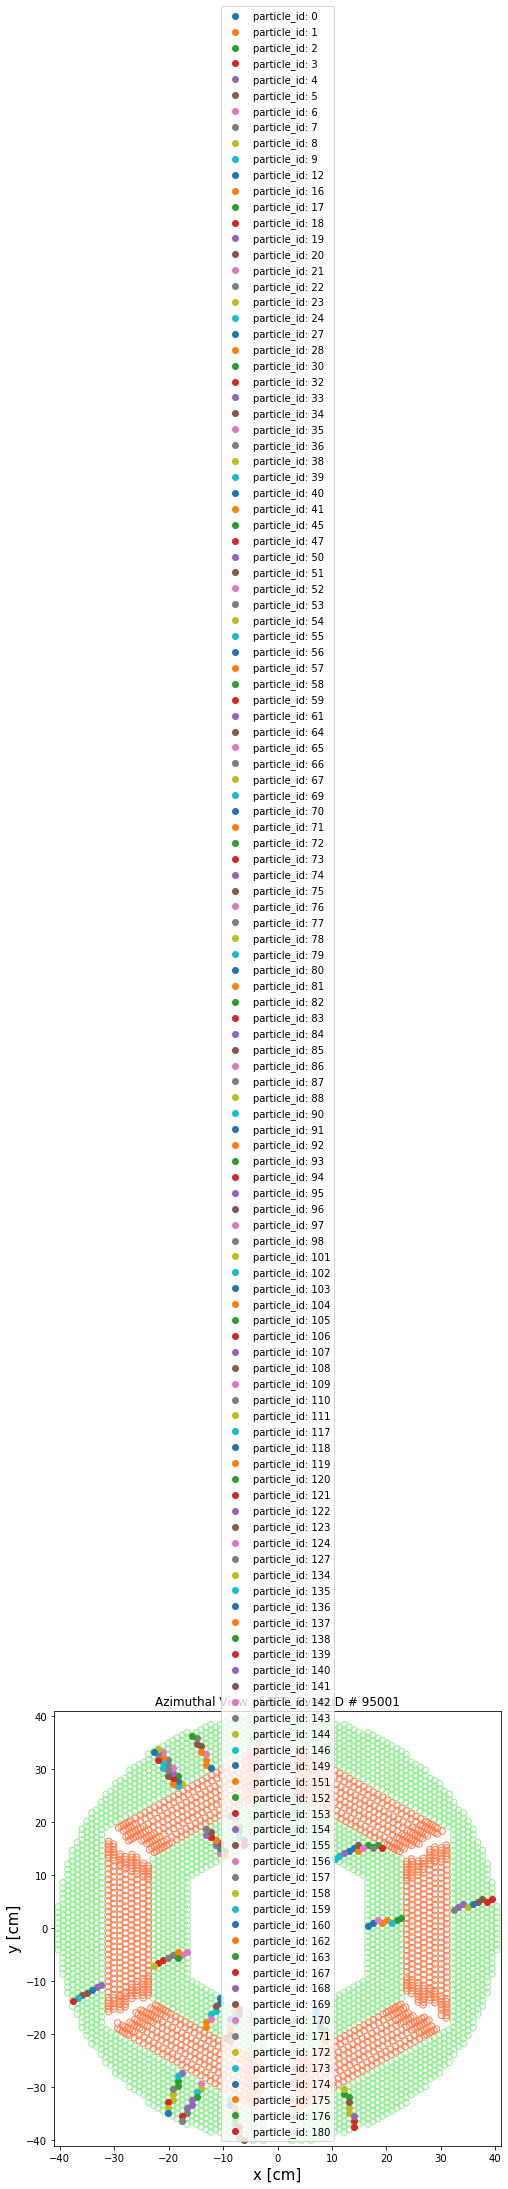

In [99]:
# plot reco event from CCL
fig, ax = detector_layout(figsize=(8,8))
t_ids = np.unique(reco_track.labels)

# here, (x,y,ir) comes from the true event,
# but idx comes from reco event from CCL

for tid in t_ids:
    idx = reco_track.labels == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### Problem

Above Plotting works with the `new_graph.labels = labels` where labels comes from `connected-component()`, But now I have assinged labels from `paths` from NetworkX. The plotting works if there is a one-one relateion between `track_id, hit_id` i.e. in `track_df` all hits that belong to same track are given a unique id. One can see this plotting in the `stt4_seg.ipynb`. 

### _Three Ways to Produce Adjacency Matrix_
There are three ways to create a sparse matrix representation of the graph with edge scores

In [ ]:
input_file = gnn_files[event_idx]

In [ ]:
os.path.split(input_file)[0], os.path.split(input_file)[1]

In [ ]:
graph = torch.load(input_file, map_location=device)

In [ ]:
# resize scores to edge_index shape
scores = graph.scores[:graph.edge_index.shape[1]]

In [ ]:
e_mask = scores > 0.5   # size reducer
passing_edges = graph.edge_index[:, e_mask]
passing_scores = scores[e_mask]
num_nodes=graph.x.size(0)

In [ ]:
graph.edge_index.shape

In [ ]:
passing_edges.shape

In [ ]:
# (1) adjacency matrix
adj_matrix = to_scipy_sparse_matrix(
    passing_edges, num_nodes=graph.x.size(0)
)

In [ ]:
# (2) adjacency matrix
adj_matrix = sps.coo_matrix(
    (np.ones(passing_edges.shape[1]), passing_edges.cpu().numpy()),
    shape=(num_nodes, num_nodes),
)

In [ ]:
# (3) adjacency matrix
adj_matrix = sps.coo_matrix(
    (passing_scores.cpu().numpy(),
     (passing_edges.cpu().numpy())
     ),
    shape=(num_nodes, num_nodes)
)